# Project: Wrangling and Analyze Data

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
<li><a href="#references">References</a></li>
</ul>

<a id='intro'></a>
## Introduction 

Hi! I'm Neto Anyama and this is my second technical project for this nanodegree course. This project specifically targets data wrangling skills. I scraped tweets from WeRateDogs' (@dog_rates) Twitter archive, using the Tweepy API. I then visually and programatically assessed, cleaned and analyzed the data.  

### Dataset Description.
- tweet_id: The last part of the tweet URL after "status/"
- date_created: The date and time each tweet was posted.
- source: The type of device the tweet was made from.
- text: The full content of the tweet.
- expanded_url: The link to each tweet.
- rating_numerator: What each dog was rated out of (mostly) 10.
- name: The name of each rated dog.
- dog_stage: Whether each dog is a doggo, floofer, pupper, puppo or none. Explanations for these groupings are contained in this [dogtionary](https://video.udacity-data.com/topher/2017/October/59e04ceb_dogtionary-combined/dogtionary-combined.png).
- favorite_count: Number of 'likes' each tweet garnered.
- retweet_count: Number of 'retweets' each tweet garnered.
- jpg_url: Link to each image contained in each tweet.
- p1: the algorithm's #1 prediction for the image in the tweet
- p1_conf: how confident the algorithm is in its #1 prediction 
- p1_dog: whether or not the #1 prediction is a breed of dog 
- p2: the algorithm's second most likely prediction
- p2_conf: how confident the algorithm is in its #2 prediction
- p2_dog: whether or not the #2 prediction is a breed of dog
- p3: the algorithm's third most likely prediction
- p3_conf: how confident the algorithm is in its #3 prediction
- p3_dog: whether or not the #3 prediction is a breed of dog

### Questions for Analysis.

At a glance, before getting into the rest of the process, I posed a few questions to be answered at the end of this analysis. These questions guided further wrangling and analysis of the data.
1. What are the top 3 dog stages by frequency?
2. What are the most liked tweets?
3. What are the most retweeted tweets?
4. What is the average level of confidence of the algorithm in its image predictions?
5. Is the prime prediction a dog species?

To begin, I imported all necessary packages for gathering, assessing, cleaning and visualizing the data.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import tweepy
import os
import matplotlib.pyplot as plt
import json
from timeit import default_timer as timer
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

In this section, there were 3 major steps taken to wrangle data:
1. Gathering.
2. Assessment.
3. Cleaning.

### Gathering.
In the cells below, I have gathered **all** three pieces of data for this project and loaded them in the notebook. 
1. I directly downloaded the WeRateDogs Twitter archive data ([twitter_archive_enhanced.csv](https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv)), then read the csv file downloaded into a pandas dataframe, `dogs`.

In [2]:
dogs = pd.read_csv('/Users/netoa/Downloads/twitter-archive-enhanced.csv')

2. Then, I used the Requests library to download the tweet image prediction (image_predictions.tsv). I read the tsv file downloaded into a pandas dataframe, `img_dogs`.

In [31]:
folder_name = 'image_predictions'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [32]:
url = ('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
response = requests.get(url)
    
with open(os.path.join(folder_name, url.split('/')[-1]), mode = 'wb') as file:
    file.write(response.content) 

In [3]:
img_dogs = pd.read_csv('image_predictions/image-predictions.tsv', sep = '\t')

   3. I then scraped Twitter's archives using Tweepy API and the tweet ids obtained from the csv file provided. The tweets were gathered into a JSON file, `tweet_json.txt`. Afterwards, I read the JSON file into a pandas dataframe, `scraped_twts`.

In [3]:
consumer_key = "HIDDEN" #Your API/Consumer key 
consumer_secret = "HIDDEN" #Your API/Consumer Secret Key
access_token = "HIDDEN"    #Your Access token key
access_token_secret = "HIDDEN" #Your Access token Secret key

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
    
api = tweepy.API(auth, wait_on_rate_limit = True)

In [6]:
#gathering all the tweet ids from twitter-archived-enhanced.csv
tweet_ids = list(dogs.tweet_id.values)
tweet_ids

[892420643555336193,
 892177421306343426,
 891815181378084864,
 891689557279858688,
 891327558926688256,
 891087950875897856,
 890971913173991426,
 890729181411237888,
 890609185150312448,
 890240255349198849,
 890006608113172480,
 889880896479866881,
 889665388333682689,
 889638837579907072,
 889531135344209921,
 889278841981685760,
 888917238123831296,
 888804989199671297,
 888554962724278272,
 888202515573088257,
 888078434458587136,
 887705289381826560,
 887517139158093824,
 887473957103951883,
 887343217045368832,
 887101392804085760,
 886983233522544640,
 886736880519319552,
 886680336477933568,
 886366144734445568,
 886267009285017600,
 886258384151887873,
 886054160059072513,
 885984800019947520,
 885528943205470208,
 885518971528720385,
 885311592912609280,
 885167619883638784,
 884925521741709313,
 884876753390489601,
 884562892145688576,
 884441805382717440,
 884247878851493888,
 884162670584377345,
 883838122936631299,
 883482846933004288,
 883360690899218434,
 883117836046

In [13]:
#gathering all the tweets into one tweet_json.txt file
count = 0
fail_dict = {}
start = timer()

with open('tweet_json.txt', 'w') as outfile:
    for id in tweet_ids:
        count +=1
        print (str(count) + ": " + str(id))
        try:
            tweet = api.get_status(id, tweet_mode = 'extended')
            print('Success')
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.errors.TweepyException as e:
            print('Fail')
            fail_dict[id] = e
            pass
end = timer()
print (end - start)
print (fail_dict)

1: 892420643555336193
Success
2: 892177421306343426
Success
3: 891815181378084864
Success
4: 891689557279858688
Success
5: 891327558926688256
Success
6: 891087950875897856
Success
7: 890971913173991426
Success
8: 890729181411237888
Success
9: 890609185150312448
Success
10: 890240255349198849
Success
11: 890006608113172480
Success
12: 889880896479866881
Success
13: 889665388333682689
Success
14: 889638837579907072
Success
15: 889531135344209921
Success
16: 889278841981685760
Success
17: 888917238123831296
Success
18: 888804989199671297
Success
19: 888554962724278272
Success
20: 888202515573088257
Fail
21: 888078434458587136
Success
22: 887705289381826560
Success
23: 887517139158093824
Success
24: 887473957103951883
Success
25: 887343217045368832
Success
26: 887101392804085760
Success
27: 886983233522544640
Success
28: 886736880519319552
Success
29: 886680336477933568
Success
30: 886366144734445568
Success
31: 886267009285017600
Success
32: 886258384151887873
Success
33: 8860541600590725

Rate limit reached. Sleeping for: 2


Success
430: 821107785811234820
Success
431: 821044531881721856
Success
432: 820837357901512704
Success
433: 820749716845686786
Success
434: 820690176645140481
Success
435: 820494788566847489
Success
436: 820446719150292993
Success
437: 820314633777061888
Success
438: 820078625395449857
Success
439: 820013781606658049
Success
440: 819952236453363712
Success
441: 819924195358416896
Success
442: 819711362133872643
Success
443: 819588359383371776
Success
444: 819347104292290561
Success
445: 819238181065359361
Success
446: 819227688460238848
Success
447: 819015337530290176
Success
448: 819015331746349057
Success
449: 819006400881917954
Success
450: 819004803107983360
Success
451: 818646164899774465
Success
452: 818627210458333184
Success
453: 818614493328580609
Success
454: 818588835076603904
Success
455: 818536468981415936
Success
456: 818307523543449600
Success
457: 818259473185828864
Success
458: 818145370475810820
Success
459: 817908911860748288
Success
460: 817827839487737858
Success


Rate limit reached. Sleeping for: 122


Success
881: 760539183865880579
Success
882: 760521673607086080
Success
883: 760290219849637889
Success
884: 760252756032651264
Success
885: 760190180481531904
Success
886: 760153949710192640
Success
887: 759943073749200896
Success
888: 759923798737051648
Fail
889: 759846353224826880
Success
890: 759793422261743616
Success
891: 759566828574212096
Fail
892: 759557299618865152
Success
893: 759447681597108224
Success
894: 759446261539934208
Success
895: 759197388317847553
Success
896: 759159934323924993
Success
897: 759099523532779520
Success
898: 759047813560868866
Success
899: 758854675097526272
Success
900: 758828659922702336
Success
901: 758740312047005698
Success
902: 758474966123810816
Success
903: 758467244762497024
Success
904: 758405701903519748
Success
905: 758355060040593408
Success
906: 758099635764359168
Success
907: 758041019896193024
Success
908: 757741869644341248
Success
909: 757729163776290825
Success
910: 757725642876129280
Success
911: 757611664640446465
Success
912: 7

Rate limit reached. Sleeping for: 513


Success
1331: 705786532653883392
Success
1332: 705591895322394625
Success
1333: 705475953783398401
Success
1334: 705442520700944385
Success
1335: 705428427625635840
Success
1336: 705239209544720384
Success
1337: 705223444686888960
Success
1338: 705102439679201280
Success
1339: 705066031337840642
Success
1340: 704871453724954624
Success
1341: 704859558691414016
Success
1342: 704847917308362754
Success
1343: 704819833553219584
Success
1344: 704761120771465216
Success
1345: 704499785726889984
Success
1346: 704491224099647488
Success
1347: 704480331685040129
Success
1348: 704364645503647744
Success
1349: 704347321748819968
Success
1350: 704134088924532736
Success
1351: 704113298707505153
Success
1352: 704054845121142784
Success
1353: 703774238772166656
Success
1354: 703769065844768768
Success
1355: 703631701117943808
Success
1356: 703611486317502464
Success
1357: 703425003149250560
Success
1358: 703407252292673536
Success
1359: 703382836347330562
Success
1360: 703356393781329922
Success
13

Rate limit reached. Sleeping for: 563


Success
1782: 677698403548192770
Success
1783: 677687604918272002
Success
1784: 677673981332312066
Success
1785: 677662372920729601
Success
1786: 677644091929329666
Success
1787: 677573743309385728
Success
1788: 677565715327688705
Success
1789: 677557565589463040
Success
1790: 677547928504967168
Success
1791: 677530072887205888
Success
1792: 677335745548390400
Success
1793: 677334615166730240
Success
1794: 677331501395156992
Success
1795: 677328882937298944
Success
1796: 677314812125323265
Success
1797: 677301033169788928
Success
1798: 677269281705472000
Success
1799: 677228873407442944
Success
1800: 677187300187611136
Success
1801: 676975532580409345
Success
1802: 676957860086095872
Success
1803: 676949632774234114
Success
1804: 676948236477857792
Success
1805: 676946864479084545
Success
1806: 676942428000112642
Success
1807: 676936541936185344
Success
1808: 676916996760600576
Success
1809: 676897532954456065
Success
1810: 676864501615042560
Success
1811: 676821958043033607
Success
18

Rate limit reached. Sleeping for: 381


Success
2233: 668221241640230912
Success
2234: 668204964695683073
Success
2235: 668190681446379520
Success
2236: 668171859951755264
Success
2237: 668154635664932864
Success
2238: 668142349051129856
Success
2239: 668113020489474048
Success
2240: 667937095915278337
Success
2241: 667924896115245057
Success
2242: 667915453470232577
Success
2243: 667911425562669056
Success
2244: 667902449697558528
Success
2245: 667886921285246976
Success
2246: 667885044254572545
Success
2247: 667878741721415682
Success
2248: 667873844930215936
Success
2249: 667866724293877760
Success
2250: 667861340749471744
Success
2251: 667832474953625600
Success
2252: 667806454573760512
Success
2253: 667801013445750784
Success
2254: 667793409583771648
Success
2255: 667782464991965184
Success
2256: 667773195014021121
Success
2257: 667766675769573376
Success
2258: 667728196545200128
Success
2259: 667724302356258817
Success
2260: 667550904950915073
Success
2261: 667550882905632768
Success
2262: 667549055577362432
Success
22

In [4]:
#reading the json file, line by line, into a pandas dataframe.
df_list = []

with open('tweet_json.txt', 'r') as scraped_tweets:
    for tweet in scraped_tweets:
        data = json.loads(tweet)
        tweet_id = data['id']
        created_at = data['created_at']
        favorite_count = data['favorite_count']
        retweet_count = data['retweet_count']
        
        df_list.append({'tweet_id' : tweet_id,
                       'created_at' : created_at,
                       'favorite_count' : favorite_count,
                       'retweet_count' : retweet_count})
    scraped_twts = pd.DataFrame(df_list, columns = ['tweet_id', 'date_created', 'favorite_count', 'retweet_count'])

### Assessment.

To assess the data, I employed both visual and programmatic methods. I observed each column to assess for issues visually. I used the `info()` and `duplicated` functions on all three dataframes to programmatically assess the data. Afterwards, I classified the issues observed into Quality and Tidiness groups.

Programmatic assessment for `dogs`:

In [4]:
dogs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [17]:
sum(dogs.duplicated())

0

In [22]:
dogs.shape

(2356, 17)

Programmatic assessment for `img_dogs`:

In [41]:
img_dogs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [42]:
sum(img_dogs.duplicated())

0

Programmatic assessment for `scraped_twts`:

In [7]:
scraped_twts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_id        2327 non-null   int64  
 1   date_created    0 non-null      float64
 2   favorite_count  2327 non-null   int64  
 3   retweet_count   2327 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 72.8 KB


In [46]:
sum(scraped_twts.duplicated())

0

Below are the issues observed: 

##### Quality
1. These columns will have their datatypes changed: `tweet_id`, `in_reply_to_status_id` and `in_reply_to_user_id` to string and `timestamp` to datetime.
2. `rating_denominator` is redundant, since we know most of the ratings are out of 10. So it will be dropped. retweeted_status_id, retweeted_status_user_id and retweeted_status_timestamp will also be dropped.
3. The newly created `dog_stage` column should be made into a categorical datatype.
4. In the `dog_stage` column, some dogs have multiple stages.
5. Some of the dog ratings are decimal numbers.
6. In the `name` column, there are several values that are not dog names, like 'a', 'the', 'such', etc.  
7. The date_created column in `scraped_twts` has all absent values.
8. The corrected figures only used the decimal places as the ratings, which was false. 


##### Tidiness
1. Doggo, floofer, pupper, puppo and None in the `dogs` table should be under the same column, `dog_stage`.
2. Timestamp in the `dogs` table will be changed to date_created and joined to the `scraped_twts` dataframe.
3. All three dataframes will merged step by step to form one master dataframe, `wrd_master_df`.


Next step, Cleaning.

### Cleaning.
Before cleaning the data, copies of each dataframe were made. Those copies will be cleaned, so as to retain the original dataframes.

In [14]:
dog_cleaned = dogs.copy()
img_clean = img_dogs.copy()
scraped_twts_clean = scraped_twts.copy()

The first issues I cleaned were the _datatype_ issues.
##### Define:
- Change the datatypes of `tweet_id`, `in_reply_to_status_id` and `in_reply_to_user_id` to object and `timestamp` to datetime, using the `astype` function. Do this as required on all three dataframes.

##### Code:

In [15]:
dog_cleaned = dog_cleaned.astype({"tweet_id":"object", "in_reply_to_status_id":"object",
                                "in_reply_to_user_id":"object",
                                "timestamp":"datetime64[ns]"
                               })

In [16]:
scraped_twts_clean = scraped_twts_clean.astype({'tweet_id':'object', 'date_created':'datetime64[ns]'})

In [17]:
img_clean = img_clean.astype({'tweet_id':'object'})

##### Test:

In [10]:
dog_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2356 non-null   object        
 1   in_reply_to_status_id       78 non-null     object        
 2   in_reply_to_user_id         78 non-null     object        
 3   timestamp                   2356 non-null   datetime64[ns]
 4   source                      2356 non-null   object        
 5   text                        2356 non-null   object        
 6   retweeted_status_id         181 non-null    float64       
 7   retweeted_status_user_id    181 non-null    float64       
 8   retweeted_status_timestamp  181 non-null    object        
 9   expanded_urls               2297 non-null   object        
 10  rating_numerator            2356 non-null   int64         
 11  rating_denominator          2356 non-null   int64       

In [18]:
scraped_twts_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   tweet_id        2327 non-null   object        
 1   date_created    0 non-null      datetime64[ns]
 2   favorite_count  2327 non-null   int64         
 3   retweet_count   2327 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 72.8+ KB


Next, I dropped seemingly irrelevant columns: `rating_denominator` (due to redundancy), `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`, `in_reply_to_status_id` and `in_reply_to_user_id`.
##### Define:
- Drop `rating_denominator`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`, `in_reply_to_status_id`, `in_reply_to_user_id` from `dog_cleaned` using `df.drop`.

##### Code:

In [16]:
dog_cleaned.rating_denominator.value_counts()

10     2333
11        3
50        3
20        2
80        2
70        1
7         1
15        1
150       1
170       1
0         1
90        1
40        1
130       1
110       1
16        1
120       1
2         1
Name: rating_denominator, dtype: int64

In [19]:
dog_cleaned = dog_cleaned[dog_cleaned.retweeted_status_id.isnull()]
dog_cleaned = dog_cleaned[dog_cleaned.retweeted_status_user_id.isnull()]
dog_cleaned = dog_cleaned[dog_cleaned.retweeted_status_timestamp.isnull()]

In [20]:
dog_cleaned.drop(['rating_denominator', 'retweeted_status_id', 
                 'retweeted_status_user_id', 'retweeted_status_timestamp', 'in_reply_to_status_id', 'in_reply_to_user_id'], axis=1, inplace=True)

##### Test:

In [21]:
dog_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   tweet_id          2175 non-null   object        
 1   timestamp         2175 non-null   datetime64[ns]
 2   source            2175 non-null   object        
 3   text              2175 non-null   object        
 4   expanded_urls     2117 non-null   object        
 5   rating_numerator  2175 non-null   int64         
 6   name              2175 non-null   object        
 7   doggo             2175 non-null   object        
 8   floofer           2175 non-null   object        
 9   pupper            2175 non-null   object        
 10  puppo             2175 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(9)
memory usage: 203.9+ KB


Next, I tackled one quality and one tidiness issue simultaneuously: 
- Doggo, floofer, pupper, puppo and None in the `dog_cleaned` table should be under the same column, `dog_stage`(Tidiness).
- The newly created `dog_stage` column should be made into a categorical datatype (Quality). 

##### Define: 
- Create a new column, `dog_stage`, using `df.loc`.
- Convert the column from an `object` to a `category` datatype.
- Use `fillna` to change the resulting null values to 'none'.
- Drop `doggo`, `floofer`, `pupper`, `puppo` using `df.drop`.

##### Code:

In [25]:
# handle none
dog_cleaned.doggo.replace('None', '', inplace=True)
dog_cleaned.floofer.replace('None', '', inplace=True)
dog_cleaned.pupper.replace('None', '', inplace=True)
dog_cleaned.puppo.replace('None', '', inplace=True)

# merge into column
dog_cleaned['dog_stage'] = dog_cleaned.doggo + dog_cleaned.floofer + dog_cleaned.pupper + dog_cleaned.puppo

# handle multiple stages
dog_cleaned.loc[dog_cleaned.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo, pupper'
dog_cleaned.loc[dog_cleaned.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo, puppo'
dog_cleaned.loc[dog_cleaned.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo, floofer'

# handle missing values
dog_cleaned.loc[dog_cleaned.dog_stage == '', 'dog_stage'] = np.nan

In [26]:
dog_cleaned.dog_stage.unique()

array([nan, 'doggo', 'puppo', 'pupper', 'floofer', 'doggo, puppo',
       'doggo, floofer', 'doggo, pupper'], dtype=object)

In [30]:
sum(dog_cleaned.dog_stage.isnull())

1831

In [31]:
dog_cleaned['dog_stage'] = dog_cleaned['dog_stage'].fillna('none')

In [32]:
dog_cleaned['dog_stage'].unique()

array(['none', 'doggo', 'puppo', 'pupper', 'floofer', 'doggo, puppo',
       'doggo, floofer', 'doggo, pupper'], dtype=object)

In [33]:
stage = ['none', 'doggo', 'puppo', 'pupper', 'floofer', 'doggo, puppo',
       'doggo, floofer', 'doggo, pupper']
stages = pd.api.types.CategoricalDtype(ordered = False, categories = stage)

In [34]:
dog_cleaned['dog_stage'] = dog_cleaned['dog_stage'].astype(stages);

In [39]:
dog_cleaned.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

##### Test:

In [40]:
dog_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   tweet_id          2175 non-null   object        
 1   timestamp         2175 non-null   datetime64[ns]
 2   source            2175 non-null   object        
 3   text              2175 non-null   object        
 4   expanded_urls     2117 non-null   object        
 5   rating_numerator  2175 non-null   int64         
 6   name              2175 non-null   object        
 7   dog_stage         2175 non-null   category      
dtypes: category(1), datetime64[ns](1), int64(1), object(5)
memory usage: 138.4+ KB


In [41]:
dog_cleaned.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,name,dog_stage
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,Phineas,none
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,Tilly,none
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,Archie,none
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,Darla,none
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,Franklin,none


Next, I renamed the `timestamp` column on `dog_cleaned` to `date_created`. This is to match with the corresponding column in the `scraped_twts_clean` dataframe, making merging possible.

##### Define:

Rename `timestamp` to `date_created` using the `df.rename` function.

##### Code:

In [42]:
dog_cleaned.rename(columns={'timestamp': 'date_created'}, inplace = True)

##### Test:

In [43]:
dog_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   tweet_id          2175 non-null   object        
 1   date_created      2175 non-null   datetime64[ns]
 2   source            2175 non-null   object        
 3   text              2175 non-null   object        
 4   expanded_urls     2117 non-null   object        
 5   rating_numerator  2175 non-null   int64         
 6   name              2175 non-null   object        
 7   dog_stage         2175 non-null   category      
dtypes: category(1), datetime64[ns](1), int64(1), object(5)
memory usage: 138.4+ KB


Next, some of the dog ratings are decimal numbers.

##### Define: 
Clean the decimal points using `df.str.contains` and a regex function.

##### Code:

In [79]:
dog_cleaned[dog_cleaned.text.str.contains(r"(\d+\.\d*\/\d+)")][['text', 'rating_numerator']]

C:\Users\netoa\AppData\Local\Temp/ipykernel_24328/2758448679.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  dog_cleaned[dog_cleaned.text.str.contains(r"(\d+\.\d*\/\d+)")][['text', 'rating_numerator']]


,text,rating_numerator
45,This is Bella. She hopes her smile made you sm...,5
695,"This is Logan, the Chow who lived. He solemnly...",75
763,This is Sophie. She's a Jubilant Bush Pupper. ...,27
1689,I've been told there's a slight possibility he...,5
1712,Here we have uncovered an entire battalion of ...,26


##### Test:

In [106]:
dog_cleaned.rating_numerator.unique()

array([  13,   12,   14,    5,   17,   11,   10,  420,  666,    6,  182,
         15,  960,    0,    7,   84,   24,   75,   27,    3,    8,    9,
          4,  165, 1776,  204,   50,   99,   80,   45,   60,   44,    1,
        143,  121,   20,   26,    2,  144,   88], dtype=int64)

The corrected figures only used the decimal places as the ratings, which was false. So, I replaced these value with the approximate ratings.

##### Define:
- Replace the decimal ratings with the approximate ratings using `df.loc`.

##### Code:

In [111]:
dog_cleaned.loc[45,"rating_numerator"]=14

In [112]:
dog_cleaned.loc[695,"rating_numerator"]=10
dog_cleaned.loc[763,"rating_numerator"]=11
dog_cleaned.loc[1689,"rating_numerator"]=10
dog_cleaned.loc[1712,"rating_numerator"]=11

##### Test:

In [115]:
dog_cleaned.rating_numerator.unique()

array([  13,   12,   14,   17,   11,   10,  420,  666,    6,  182,   15,
        960,    0,    7,   84,   24,    5,    3,    8,    9,    4,  165,
       1776,  204,   50,   99,   80,   45,   60,   44,    1,  143,  121,
         20,    2,  144,   88], dtype=int64)

The next quality issue I was in the `name` column of `dog_cleaned`. There are several values that are not dog names, like 'a', 'the', 'such', etc. It is important to note that all the outlier names are in lower case text.

###### Define:
- Create a list of unique names using `list(df.column.unique())`.
- Use a `for` loop to create a list of names in all lower case text.
- Use `df.replace` to change all the values to None.

##### Code:

In [89]:
list_name = list(dog_cleaned.name.unique())

In [102]:
    for name in list_name:
        if name.islower():
            print(name)

such
a
quite
not
one
incredibly
very
my
his
an
actually
just
getting
mad
this
unacceptable
all
old
infuriating
the
by
officially
life
light
space


In [103]:
dog_cleaned.name.replace(['such', 'a', 'quite', 'not','one','incredibly','very','my','his','an','actually',
'just','getting','mad','this','unacceptable','all','old','infuriating','the','by','officially','life','light','space'], 'None', 
                         inplace = True)

##### Test:

In [105]:
list_names = list(dog_cleaned.name.unique())
for name in list_names:
    if name.islower():
        print(name)

There were no given results.


The next issue to be fixed is that all the values under `date_created` in `scraped_twts_clean` are null (missing). The `dog_cleaned` and `scraped_twts_clean` dataframes will be used simultaneuously.

##### Define:
- Get the dimensions of `dog_cleaned` and `scraped_twts_clean` using `shape`.
- Obtain the ids that had no tweets scraped from them and create a query, `fail_id_q`, to get the indices of the ids under `dog_cleaned`.
- Drop the rows from `dog_cleaned` containing those ids.
- Merge `dog_cleaned` and `scraped_twts_clean` on tweet_id.

##### Code:

In [44]:
dog_cleaned.shape

(2175, 8)

In [45]:
scraped_twts_clean.shape

(2327, 4)

In [50]:
fail_id_q = dog_cleaned.query('tweet_id == [872261713294495745, 844704788403113984, 837366284874571778, 829374341691346946, 779123168116150273, 759923798737051648, 754011816964026368, 680055455951884288]')

In [51]:
fail_id_q

,tweet_id,date_created,source,text,expanded_urls,rating_numerator,name,dog_stage
104,872261713294495745,2017-06-07 01:19:32,"<a href=""http://twitter.com/download/iphone"" r...",This is Harry. His ears are activated one at a...,https://twitter.com/dog_rates/status/872261713...,13,Harry,none
253,844704788403113984,2017-03-23 00:18:10,"<a href=""http://twitter.com/download/iphone"" r...",This is Luna. It's her first time outside and ...,https://twitter.com/dog_rates/status/844704788...,13,Luna,none
296,837366284874571778,2017-03-02 18:17:34,"<a href=""http://twitter.com/download/iphone"" r...",This is Lucy. She has a portrait of herself on...,https://twitter.com/dog_rates/status/837366284...,13,Lucy,none
363,829374341691346946,2017-02-08 17:00:26,"<a href=""http://twitter.com/download/iphone"" r...",This is Astrid. She's a guide doggo in trainin...,https://twitter.com/dog_rates/status/829374341...,13,Astrid,doggo
750,779123168116150273,2016-09-23 01:00:13,"<a href=""http://twitter.com/download/iphone"" r...",This is Reggie. He hugs everyone he meets. 12/...,https://twitter.com/dog_rates/status/779123168...,12,Reggie,none
887,759923798737051648,2016-08-01 01:28:46,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs... this is a Taiwanese Guide...,https://twitter.com/dog_rates/status/759923798...,10,None,none
932,754011816964026368,2016-07-15 17:56:40,"<a href=""http://twitter.com/download/iphone"" r...",This is Charlie. He pouts until he gets to go ...,https://twitter.com/dog_rates/status/754011816...,12,Charlie,none
1726,680055455951884288,2015-12-24 16:00:30,"<a href=""https://about.twitter.com/products/tw...","Meet Sammy. At first I was like ""that's a snow...",https://twitter.com/dog_rates/status/680055455...,10,Sammy,none


In [52]:
dog_cleaned.drop([104, 253, 296,
                363, 750, 887, 932, 1726
                  ], axis = 0, inplace = True)

In [53]:
dog_cleaned.shape

(2167, 8)

In [116]:
dog_twt = pd.merge(dog_cleaned, scraped_twts_clean, how='inner', on=['tweet_id'])

In [117]:
dog_twt.shape

(2167, 11)

In [119]:
dog_twt.drop('date_created_y', axis =1, inplace = True)

In [120]:
dog_twt.rename(columns={'date_created_x': 'date_created'}, inplace = True)

##### Test:

In [121]:
dog_twt.head()

,tweet_id,date_created,source,text,expanded_urls,rating_numerator,name,dog_stage,favorite_count,retweet_count
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,Phineas,none,33701,6976
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,Tilly,none,29231,5278
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,Archie,none,21975,3466
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,Darla,none,36781,7190
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,Franklin,none,35161,7721


In [76]:
dog_twt.shape

(2167, 10)

Finally, I merged `img_clean` to `dog_twt` to create a master dataframe, `wrd_master_df`. For clarity, "wrd" here means "WeRateDogs". 

##### Define:

- Perform a left merge of `img_clean` to `dog_twt` using `df.merge`.

##### Code:

In [122]:
img_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [123]:
wrd_master_df = dog_twt.merge(img_clean, how = 'left')

##### Test:

In [124]:
wrd_master_df.head()

,tweet_id,date_created,source,text,expanded_urls,rating_numerator,name,dog_stage,favorite_count,retweet_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,Phineas,none,33701,6976,...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,Tilly,none,29231,5278,...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,Archie,none,21975,3466,...,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,Darla,none,36781,7190,...,1.0,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,Franklin,none,35161,7721,...,2.0,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


In [125]:
wrd_master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2167 entries, 0 to 2166
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   tweet_id          2167 non-null   object        
 1   date_created      2167 non-null   datetime64[ns]
 2   source            2167 non-null   object        
 3   text              2167 non-null   object        
 4   expanded_urls     2109 non-null   object        
 5   rating_numerator  2167 non-null   int64         
 6   name              2167 non-null   object        
 7   dog_stage         2167 non-null   category      
 8   favorite_count    2167 non-null   int64         
 9   retweet_count     2167 non-null   int64         
 10  jpg_url           1986 non-null   object        
 11  img_num           1986 non-null   float64       
 12  p1                1986 non-null   object        
 13  p1_conf           1986 non-null   float64       
 14  p1_dog            1986 n

### Saving the Cleaned Dataset.

Finally, we have a cleaner and more organized dataset, ready for analysis! The dataset, `wrd_master_df` was saved as a csv file, `twitter_archive_master.csv`.

In [126]:
wrd_master_df.to_csv('twitter_archive_master.csv', index=False)

<a id='eda'></a>
## Exploratory Data Analysis.


Now, it is time to perform exploratory data analysis: visualize the data and answer the questions. To do this, I imported `pandas` to load and read the cleaned data, `seaborn` and `matplotlib.pyplot` and `%matplotlib inline` to visualize and view my visualizations as I go. To reiterate, and for ease of the reader, here are the questions:

1. What are the top 3 dog stages by frequency?
2. What are the most liked tweets?
3. What are the most retweeted tweets?
4. What is the average level of confidence of the algorithm in its image predictions?
5. Is the prime prediction a dog species?

I decided to use saddlebag brown (#8B4513) and salmon pink (#FA8072) on grey backgrounds as my main [colours](https://www.geeksforgeeks.org/html-hex-color-codes/) for visualization. This is because they remind me of the brown fur and pink tongue of certain dogs.

Before getting into the analysis, I loaded the master csv file into a pandas dataframe, `we_rate_dogs`.

In [127]:
we_rate_dogs = pd.read_csv('twitter_archive_master.csv')
sns.set_style("dark")

### Research Question 1: What are the top 3 dog stages by frequency?

To answer this question, I plotted a bar chart of all the dog stages. To include the bar labels, I used [this](https://stackoverflow.com/questions/68320207/how-to-get-the-label-values-on-a-bar-chat-with-seaborn-on-a-categorical-data).

In [128]:
freq = we_rate_dogs.dog_stage.value_counts()
stage_order = freq.index

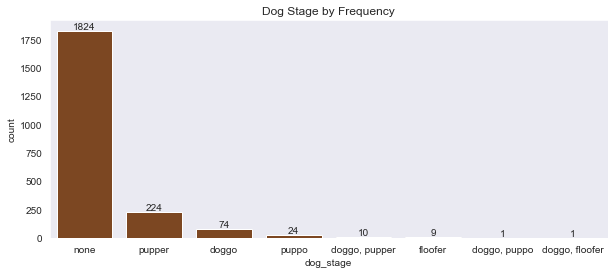

In [131]:
plt.figure(figsize=(10,4))
ax = sns.countplot(data = we_rate_dogs, x = 'dog_stage', color = '#8B4513', order = stage_order);
plt.bar_label(ax.containers[0]); # plot bar labels
plt.title('Dog Stage by Frequency');

In [132]:
we_rate_dogs.dog_stage.value_counts(normalize=True)

none              0.841717
pupper            0.103369
doggo             0.034149
puppo             0.011075
doggo, pupper     0.004615
floofer           0.004153
doggo, puppo      0.000461
doggo, floofer    0.000461
Name: dog_stage, dtype: float64

The above chart shows that **1824 (84.17%)** of all the dogs are ungrouped. However, of the dogs that _are_ grouped, **puppers** are the most common.  

### Research Questions 2 & 3: What are the most liked tweets? What are the most retweeted tweets?

To answer these questions, I created a dataframe containing the full information of the 5 tweets with the most interactions (likes and retweets). This was done using pandas' [`df.nlargest`](https://datascientyst.com/get-top-10-highest-lowest-values-pandas/). Then, I plotted a clustered bar chart to visualize the results.

In [133]:
top_interactions = we_rate_dogs.nlargest(n=5, columns=['favorite_count', 'retweet_count'])
top_interactions

,tweet_id,date_created,source,text,expanded_urls,rating_numerator,name,dog_stage,favorite_count,retweet_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
855,744234799360020481,2016-06-18 18:26:18,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo realizing you can stand in a po...,https://twitter.com/dog_rates/status/744234799...,13,None,doggo,144265,70395,...,1.0,Labrador_retriever,0.825333,True,ice_bear,0.044681,False,whippet,0.018442,True
344,822872901745569793,2017-01-21 18:26:02,"<a href=""http://twitter.com/download/iphone"" r...",Here's a super supportive puppo participating ...,https://twitter.com/dog_rates/status/822872901...,13,None,puppo,123630,39799,...,1.0,Lakeland_terrier,0.196015,True,Labrador_retriever,0.160329,True,Irish_terrier,0.069126,True
441,807106840509214720,2016-12-09 06:17:20,"<a href=""http://twitter.com/download/iphone"" r...",This is Stephan. He just wants to help. 13/10 ...,https://twitter.com/dog_rates/status/807106840...,13,Stephan,none,111220,51464,...,1.0,Chihuahua,0.505370,True,Pomeranian,0.120358,True,toy_terrier,0.077008,True
118,866450705531457537,2017-05-22 00:28:40,"<a href=""http://twitter.com/download/iphone"" r...",This is Jamesy. He gives a kiss to every other...,https://twitter.com/dog_rates/status/866450705...,13,Jamesy,pupper,108502,30079,...,2.0,French_bulldog,0.905334,True,Boston_bull,0.078060,True,pug,0.001771,True
894,739238157791694849,2016-06-04 23:31:25,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo blowing bubbles. It's downright...,https://twitter.com/dog_rates/status/739238157...,13,None,doggo,106781,52675,...,1.0,Eskimo_dog,0.503372,True,Siberian_husky,0.390413,True,malamute,0.080901,True


In [134]:
Dog_Names=['A', 'B', 'C', 'D', 'E']
favorite_count=list(top_interactions.favorite_count)
retweet_count= list(top_interactions.retweet_count)

In [135]:
ind = np.arange(len(favorite_count))  # the x locations for the groups
width = 0.35       # the width of the bars

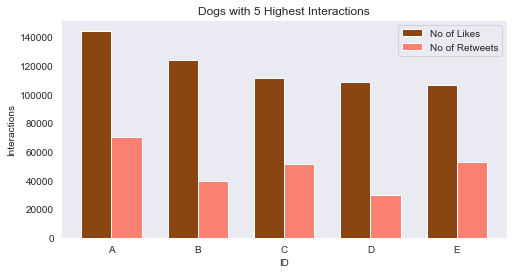

In [136]:
plt.figure(figsize=(8,4))

favorite_bars = plt.bar(ind, favorite_count, width, color='#8B4513', alpha=1, label='No of Likes')
retweet_bars = plt.bar(ind + width, retweet_count, width, color='#FA8072', alpha=1, label='No of Retweets')

# title and labels
plt.ylabel('Interactions')
plt.xlabel('ID')
plt.title('Dogs with 5 Highest Interactions')
locations = ind + width / 2  # xtick locations
labels = Dog_Names  # xtick labels
plt.xticks(locations, labels);

# legend
plt.legend(frameon=True);

In [144]:
top_interactions.tweet_id.unique()

array([744234799360020481, 822872901745569793, 807106840509214720,
       866450705531457537, 739238157791694849], dtype=int64)

The tweet ids represented by A-E are as follows:

> A: 744234799360020481

> B: 822872901745569793

> C: 807106840509214720

> D: 866450705531457537 

> E: 739238157791694849

The clustered bar chart shows that **A (tweet id 744234799360020481)** has the highest amount of total interactions with 144,265 likes and 70,395 retweets. 

### Research Question 4: What is the average level of confidence of the algorithm in its image predictions?
As explained in the dataset description in my introduction to this project, the algorithm made three predictions of whether the included pictures in each tweet were actually of different dog species. These predictions were labelled p1, p2 and p3. It also had varying levels of confidence in the predictions made, represented as p1_conf, p2_conf and p3_conf, respectively.

To calculate the average level of the confidence in each of the three predictions, I used the `df.describe()` function.

In [137]:
we_rate_dogs[['p1_conf', 'p2_conf', 'p3_conf']].describe()

,p1_conf,p2_conf,p3_conf
count,1986.000000,1.986000e+03,1.986000e+03
mean,0.593452,1.344853e-01,6.034994e-02
std,0.271961,1.005944e-01,5.091948e-02
min,0.044333,1.011300e-08,1.740170e-10
25%,0.362656,5.407533e-02,1.624755e-02
50%,0.587357,1.175370e-01,4.952715e-02
75%,0.844920,1.951377e-01,9.166433e-02
max,1.000000,4.880140e-01,2.734190e-01


From the above table, the average confidence of the algorithm in its first, second and third predictions are **59.345%, 0.134% and 0.0603%**, respectively.

### Research Question 5: Is the prime prediction a dog species?
In this question, we want to know how often the algorithm's first prediction was a dog species. This is to test just how viable the algorithm is in its image predictions. To do this, I used the `value_counts` function, including the `normalize=True` argument to get the proportions. Afterwards, I plotted a doughnut chart to visualize my results.

In [138]:
we_rate_dogs.p1_dog.value_counts(normalize=True)

True     0.739678
False    0.260322
Name: p1_dog, dtype: float64

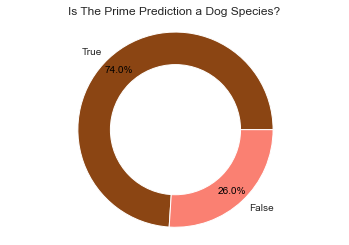

In [139]:
y = [73.97, 26.03]
mylabels = ['True', 'False']
patches, texts, autotexts=plt.pie(y, labels = mylabels, radius=1.5, colors=('#8B4513', '#FA8072'),
       autopct='%1.1f%%', pctdistance=0.85)

for autotext in autotexts:
    autotext.set_color('black')
    
centre_circle = plt.Circle((0,0),1.0,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Is The Prime Prediction a Dog Species?')
plt.axis('equal')  

plt.show();

The doughnut chart showed that **74.0%** of the first predictions were actually dog species (represented by True).

<a id='conclusions'></a>
## Conclusions.

The inferences obtained from the above visualization are as follows:
1. **1824 (84.17%)** of all the dogs are ungrouped. However, of the dogs that _are_ grouped, **puppers** are the most common. 
2. **A (tweet id 744234799360020481)** has the highest amount of total interactions with 144,265 likes and 70,395 retweets. 
3. The average confidence of the algorithm in its first, second and third predictions are **59.345%, 0.134% and 0.0603%**, respectively.
4. **74.0%** of the first predictions were actually dog species (represented by True).

### Limitations.
1. Not all the tweets could be scraped, as they were available.
2. Of the tweets scraped, not all of them had image predictions. This may have been because not all the tweets had images in them.

<a id='references'></a>
## References

1. [Tutorial: Add a Column to a Pandas DataFrame Based on an If-Else Condition](https://www.dataquest.io/blog/tutorial-add-column-pandas-dataframe-based-on-if-else-condition/)
2. [Data Analytics with Pandas – How to Drop a List of Rows from a Pandas Dataframe](https://www.freecodecamp.org/news/drop-list-of-rows-from-pandas-dataframe/#:~:text=To%20drop%20a%20row%20or%20column%20in%20a%20dataframe%2C%20you,method%20in%20the%20docs%20here.&text=Rows%20are%20labelled%20using%20the,Columns%20are%20labelled%20using%20names.)
3. [Merge, join, concatenate and compare](https://pandas.pydata.org/docs/user_guide/merging.html)
4. [Joining two unequal dataframes](https://stackoverflow.com/questions/43314859/joining-two-unequal-dataframes)
5. [HTML Hex Color Codes](https://www.geeksforgeeks.org/html-hex-color-codes/)
6. [How to Get Top 10 Highest or Lowest Values in Pandas](https://datascientyst.com/get-top-10-highest-lowest-values-pandas/)
7. [Only print the lowercase characters in a string](https://stackoverflow.com/questions/34446322/only-print-the-lowercase-characters-in-a-string)
8. [Replace Values Based On Index In Pandas Dataframes](https://predictivehacks.com/?all-tips=replace-values-based-on-index-in-pandas-dataframes)
9. https://files.slack.com/files-pri/T03N50X8SE6-F040G6Q5KTJ/screenshot_pylist2.png 
10. https://video.udacity-data.com/topher/2018/November/5be5fb4c_twitter-api/twitter-api.py